In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = "Data/example-file.csv"

In [3]:
# Read transaction data
transactions_raw = pd.read_csv(DATA_PATH)
transactions_raw = transactions_raw.sort_values("LAST_TXN_DTE")
transactions_raw.head()

,COLLECTOR_KEY,LAST_TXN_DTE,FGC,target,trans,recency,pc,pci,si,flag_AIR,...,flag_ls_se,flag_f,flag_m,age,tenure,flag_on,dist,SHOPPED_L2W,LOADED_L2W,RECOMMENDED_L2W
130732,1294377,20160630,21084,0,0,NaN,185.0,1.972973,1.255373,0,...,0,1,0,61.0,26,0,0.575,0,0,0
40189,364654,20160630,111776,0,0,NaN,34.0,10.735294,1.200583,0,...,0,1,0,43.0,82,1,99.294,0,0,0
40190,364654,20160630,111778,0,0,NaN,63.0,5.793651,0.678551,0,...,0,1,0,43.0,82,1,99.294,0,0,0
172486,1660464,20160630,9604,0,0,NaN,90.0,4.055556,0.926189,0,...,0,1,0,55.0,85,1,163.274,0,0,0
36471,338037,20160630,71292,0,0,NaN,80.0,4.562500,1.218462,0,...,0,1,0,42.0,32,0,2.189,0,0,0


Number of users:  693

Distribution of orders: 


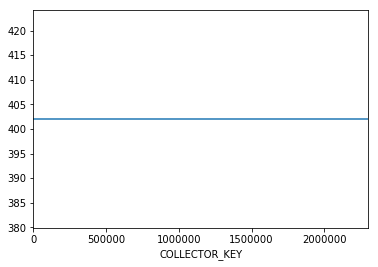

[402]


In [4]:
print("Number of users: ", len(transactions_raw["COLLECTOR_KEY"].unique()))
print()

print("Distribution of orders: ")
transactions_raw.groupby(by="COLLECTOR_KEY")["FGC"].count().plot()
plt.show()
print(transactions_raw.groupby(by="COLLECTOR_KEY")["FGC"].count().unique())

### Format categorical data

In [5]:
transactions_fgc_encoded = transactions_raw.copy()
dummies = pd.get_dummies(transactions_raw["FGC"])
# Keep hold of new categories real values
dummyMapper = list(dummies.columns)
transactions_fgc_encoded = pd.concat([transactions_fgc_encoded, dummies], axis=1)

del dummies
del transactions_raw

transactions_fgc_encoded = transactions_fgc_encoded.drop(["FGC", "LAST_TXN_DTE", "recency"], axis=1)

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

transactions_fgc_encoded.loc[:, "target":] = scaler.fit_transform(transactions_fgc_encoded.loc[:, "target":])

### Create a dynamic user representation in matrix
This creates a set of N orders, where N-1 are used for input and the model will predict the next order. This way it can learn the trends and patterns in orders instead of learning user -> order mapping.

In [7]:
dynamic_user_order_sets = []
dynamic_user_target_values = []

lim = 10  # Orders in one set
MAX_SAMPLES = 3000 # or None for maximum samples (more RAM required)

for name, group in transactions_fgc_encoded.groupby(by="COLLECTOR_KEY"):
    if MAX_SAMPLES and len(dynamic_user_order_sets) >= MAX_SAMPLES:
            break
    
    for i in range(0, len(group)-lim-1):
        if MAX_SAMPLES and len(dynamic_user_order_sets) >= MAX_SAMPLES:
            break
        try:
            order_seq = group.values[i:i+lim-1,1:]
            next_order = group.values[i+lim, -len(dummyMapper):]
            dynamic_user_order_sets.append(order_seq)
            dynamic_user_target_values.append(next_order)
        except IndexError:
            break
        except MemoryError:
            break
del transactions_fgc_encoded

In [8]:
# Convert to 3 Dimensional Numpy arrays and reverse the axis
dynamic_user_order_sets = np.rollaxis(np.dstack(dynamic_user_order_sets), -1)
dynamic_user_target_values = np.rollaxis(np.dstack(dynamic_user_target_values), -1)

print(dynamic_user_order_sets.shape, dynamic_user_target_values.shape)

(3000, 9, 460) (3000, 1, 402)


In [9]:
dynamic_user_target_values = dynamic_user_target_values.reshape(dynamic_user_target_values.shape[0],\
                                                                dynamic_user_target_values.shape[2])
dynamic_user_target_values.shape

(3000, 402)

In [10]:
np.save("dynamic_user_order_sets", dynamic_user_order_sets)
np.save("dynamic_user_target_values", dynamic_user_target_values)
np.save("dummyMapper", dummyMapper)

## DREAM Model
It takes the sequence of transactions and using RNNs predicts what the next transaction might be of

Input -> LSTM -> LSTM -> Feed-Forward -> Softmax (Output)

In [11]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Reshape, LSTM

Using TensorFlow backend.


In [12]:
class DREAM:
    def __init__(self, input_shape, uniqueFGCs, activation,
                optimizer="adagrad", loss="categorical_crossentropy", metrics=["accuracy"]):
        self.model = Sequential()
        
        self.model.add( LSTM(units=100,
                        return_sequences=True,
                        unroll=True,
                        input_shape=input_shape) )
        self.model.add( LSTM(units=32,
                        return_sequences=False,
                        unroll=True) )
        self.model.add( Dropout(rate=0.5) )
        self.model.add( Dense(units=550,
                             activation="relu") )
        self.model.add( Dense(uniqueFGCs, activation='softmax') )
        
        self.model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
        
    def get_model(self):
        return self.model
    
    def predict(self, x):
        return self.model.predict(x)

In [13]:
dream_model = DREAM(input_shape=dynamic_user_order_sets.shape[1:],
                    uniqueFGCs=len(dummyMapper),
                    activation="relu",
                    optimizer="adamax",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [14]:
dream_model.get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 100)            224400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 550)               18150     
_________________________________________________________________
dense_2 (Dense)              (None, 402)               221502    
Total params: 481,076
Trainable params: 481,076
Non-trainable params: 0
_________________________________________________________________


Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 3s - loss: 6.0079 - acc: 7.4074e-04 - val_loss: 5.9984 - val_acc: 0.0000e+00
Epoch 2/20
2700/2700 [==============================] - 1s - loss: 5.9967 - acc: 0.0019 - val_loss: 5.9984 - val_acc: 0.0033
Epoch 3/20
2700/2700 [==============================] - 1s - loss: 5.9956 - acc: 0.0015 - val_loss: 5.9997 - val_acc: 0.0000e+00
Epoch 4/20
2700/2700 [==============================] - ETA: 0s - loss: 5.9945 - acc: 0.001 - 1s - loss: 5.9945 - acc: 0.0019 - val_loss: 6.0024 - val_acc: 0.0033
Epoch 5/20
2700/2700 [==============================] - 1s - loss: 5.9921 - acc: 0.0037 - val_loss: 6.0032 - val_acc: 0.0000e+00
Epoch 6/20
2700/2700 [==============================] - 1s - loss: 5.9877 - acc: 0.0019 - val_loss: 6.0086 - val_acc: 0.0000e+00
Epoch 7/20
2700/2700 [==============================] - 1s - loss: 5.9777 - acc: 0.0052 - val_loss: 6.0209 - val_acc: 0.0033
Epoch 8/20
2700/2700

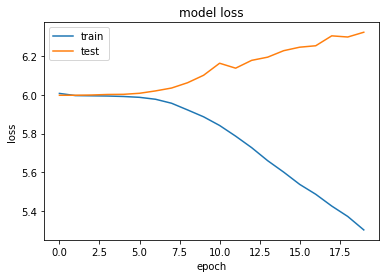

In [15]:
history = dream_model.model.fit(dynamic_user_order_sets, dynamic_user_target_values,\
                      epochs=20, batch_size=64, validation_split=0.1)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
pred = dream_model.predict( np.rollaxis( np.dstack( [ dynamic_user_order_sets[0] ] ), -1) )

print("Got:",dummyMapper[np.argmax(pred[0])], " Needed:", dummyMapper[np.argmax(dynamic_user_target_values[0])])

Got: 29070  Needed: 33714
